In [1]:
# Import libraries
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver import ActionChains
from webdriver_manager.chrome import ChromeDriverManager

import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime

In [2]:
# Initialize browser
driver = webdriver.Chrome(ChromeDriverManager().install())
url = 'https://www.arcgis.com/apps/opsdashboard/index.html#/75133e049f584ae8b51dc6cba740009a'
driver.get(url)

# Wait
driver.implicitly_wait(10)

# Click on history of tests performed 
element1 = driver.find_element_by_id("ember209")
ActionChains(driver).click(element1).perform()

# Click on history of reported positive cases 
element2 = driver.find_element_by_id("ember239")
ActionChains(driver).click(element2).perform()

# Wait
driver.implicitly_wait(10)

# Store page HTML
soup = BeautifulSoup(driver.page_source, 'html.parser')
driver.quit()

[WDM] - Current google-chrome version is 83.0.4103
[WDM] - Get LATEST driver version for 83.0.4103
[WDM] - Driver [C:\Users\karla\.wdm\drivers\chromedriver\win32\83.0.4103.39\chromedriver.exe] found in cache


In [10]:
# Extract <div> containing data on total tests performed
elements_total_tests = soup.findAll('div', {'id': 'ember91'})[0].findAll('g')

# Extract data on total tests performed
total_tests = {'Date': [], 'Total_Tests': []}
for element in elements_total_tests:
    try:
        split_element = element['aria-label'].split()
        total_tests['Total_Tests'].append( int(split_element[-1]) )
        total_tests['Date'].append( ' '.join(split_element[4:7]) )
    except:
        pass
    
# Convert dict to pandas df
total_tests_df = pd.DataFrame.from_dict(total_tests)
total_tests_df['Date'] = pd.to_datetime(total_tests_df['Date'], format='%b %d, %Y')
total_tests_df.set_index('Date', inplace=True)

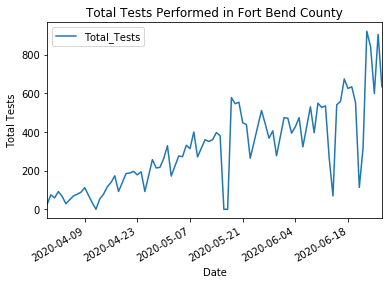

In [14]:
# Plot total tests performed
total_tests_df.plot()
plt.title('Total Tests Performed in Fort Bend County')
plt.ylabel('Total Tests')
plt.show()

In [12]:
# Extract <div> containing data on total positive cases 
elements_total_positive_cases = soup.findAll('div', {'id': 'ember144'})[0].findAll('g')

# Extract data on total positive cases
total_positive_cases = {'Date': [], 'Total_Cases': []}
for element in elements_total_positive_cases:
    try:
        split_element = element['aria-label'].split()
        total_positive_cases['Total_Cases'].append( int(split_element[-1]) )
        total_positive_cases['Date'].append( ' '.join(split_element[2:5]) )
    except:
        pass
    
# Convert dict to pandas df
total_positive_cases_df = pd.DataFrame.from_dict(total_positive_cases)
total_positive_cases_df['Date'] = pd.to_datetime(total_positive_cases_df['Date'], format='%b %d, %Y')
total_positive_cases_df.set_index('Date', inplace=True)

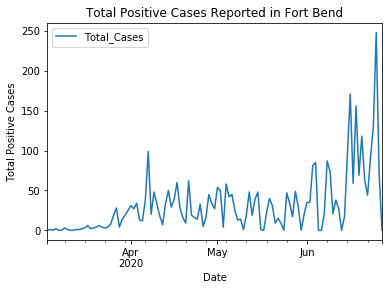

In [15]:
# Plot total positive cases reported
total_positive_cases_df.plot()
plt.title('Total Positive Cases Reported in Fort Bend')
plt.ylabel('Total Positive Cases')
plt.show()